<a href="https://colab.research.google.com/github/shreysingla11/3D-project/blob/master/Hand_Gestures_densenet131.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
data_dir = '/content/gdrive/My Drive/Handgestures/'

train_dir = data_dir + 'train/'
valid_dir = data_dir + 'valid/'
test_dir = data_dir + 'test/'

batch_size = 64
save_file_name = 'densenet131-handgestures.pt'

In [0]:
train_on_gpu = cuda.is_available()
print('Train on gpu :',train_on_gpu)
multi_gpu = False

Train on gpu : True


In [0]:
def imshow(image):
    plt.figure(figsize=(6,6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


In [0]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [0]:
def imshow_tensor(image,ax=None,title=None):
    if ax is None:
        fig,ax = plt.subplots()
    image = image.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image,0,1)
    ax.imshow(image)
    plt.axis('off')
    return ax,image

In [0]:
# Datasets from each folder
data = {
    'train':
    datasets.ImageFolder(root=train_dir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=valid_dir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=test_dir, transform=image_transforms['test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

In [0]:
def get_pretrained_densenet(model_name):
    """Retrieve a pre-trained model from torchvision

    Params
    -------
        model_name (str): name of the model (currently only accepts vgg16 and resnet50)

    Return
    --------
        model (PyTorch model): cnn

    """

    if model_name == 'densenet121_1':
        model = models.densenet121(pretrained=True)
        
        for param in model.parameters():
            param.requires_grad = False
        
        model.classifier = nn.Sequential(
            nn.Linear(1024,5),nn.LogSoftmax(dim=1)
        )
    if model_name == 'densenet121_2':
        model = models.densenet121(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False
        
        model.classifier = nn.Sequential(
            nn.Linear(1024,256),nn.ReLU(),
            nn.Linear(256,5),nn.LogSoftmax(dim=1)
        )
    if model_name == 'densenet121_3':
        model = models.densenet121(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False
        
        model.classifier = nn.Sequential(
            nn.Linear(1024,256),nn.ReLU(),nn.Dropout(0.5),
            nn.Linear(256,5),nn.LogSoftmax(dim=1)
        )

    # Move to gpu and parallelize
    if train_on_gpu:
        model = model.to('cuda')

    return model

In [0]:
model1 = get_pretrained_densenet('densenet121_1')
criterion = nn.NLLLoss()
optimizer = optim.Adam(model1.parameters())
#lets check the trainable parameters
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)
       

torch.Size([5, 1024])
torch.Size([5])


In [0]:
model1.class_to_idx = data['train'].class_to_idx
model1.idx_to_class = {
    idx: class_
    for class_, idx in model1.class_to_idx.items()
}

list(model1.idx_to_class.items())

[(0, 'L'), (1, 'fantastic'), (2, 'fist'), (3, 'palm'), (4, 'victory')]

In [0]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20):
         
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    
    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            #print(ii)
            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()
            
            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            #print(f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.')
                
                

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                
                print(
                    f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                )
                print(
                    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [0]:
model1_trained, history = train(
    model1,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=6,
    n_epochs=50)
    

Starting Training from Scratch.


Epoch: 0 	Training Loss: 1.4726 	Validation Loss: 1.2699
		Training Accuracy: 39.63%	 Validation Accuracy: 58.52%

Epoch: 1 	Training Loss: 1.0568 	Validation Loss: 0.9944
		Training Accuracy: 73.12%	 Validation Accuracy: 78.41%

Epoch: 2 	Training Loss: 0.8141 	Validation Loss: 0.8296
		Training Accuracy: 82.93%	 Validation Accuracy: 83.98%

Epoch: 3 	Training Loss: 0.6720 	Validation Loss: 0.7230
		Training Accuracy: 86.85%	 Validation Accuracy: 88.03%

Epoch: 4 	Training Loss: 0.5816 	Validation Loss: 0.6534
		Training Accuracy: 87.38%	 Validation Accuracy: 87.69%

Epoch: 5 	Training Loss: 0.5135 	Validation Loss: 0.6120
		Training Accuracy: 88.95%	 Validation Accuracy: 88.20%

Epoch: 6 	Training Loss: 0.4633 	Validation Loss: 0.5637
		Training Accuracy: 91.53%	 Validation Accuracy: 88.87%

Epoch: 7 	Training Loss: 0.4258 	Validation Loss: 0.5543
		Training Accuracy: 91.12%	 Validation Accuracy: 86.17%

Epoch: 8 	Training Loss: 0.3992 	Validation Lo

Text(0.5, 1.0, 'Training and Validation Losses')

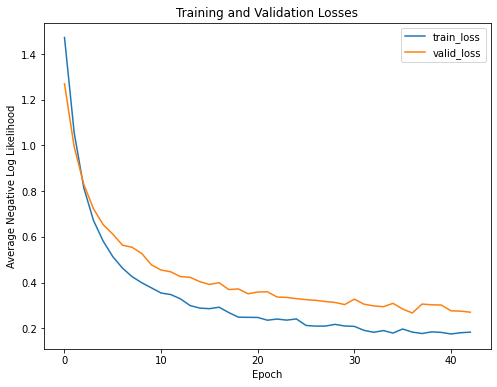

In [0]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

Text(0.5, 1.0, 'Training and Validation Accuracy')

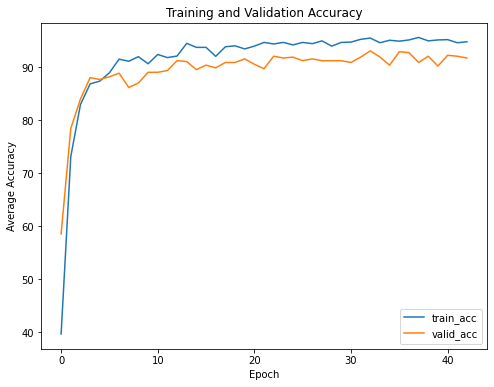

In [0]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

In [0]:
def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path)
    # Resize
    img = image.resize((256, 256))

    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

In [0]:
def predict(image_path, model, topk=2):
    """Make a prediction for an image using a trained model

    Params
    --------
        image_path (str): filename of the image
        model (PyTorch model): trained model for inference
        topk (int): number of top predictions to return

    Returns

    """
    real_class = image_path.split('/')[-2]

    # Convert to pytorch tensor
    img_tensor = process_image(image_path)

    # Resize
    if train_on_gpu:
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)

    # Set to evaluation
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        ps = torch.exp(out)

        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim=1)

        # Extract the actual classes and probabilities
        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes, real_class

[0.9637672 0.0336661] ['victory', 'fantastic'] victory


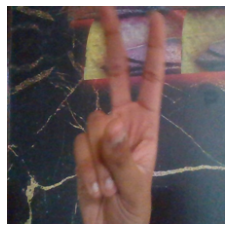

In [0]:
img_path = test_dir + '/victory/image_101.jpg'
img, top_p, top_classes, real_class = predict(img_path, model1_trained)
_ = imshow_tensor(img)
print(top_p, top_classes, real_class)

In [0]:
def accuracy(output, target, topk=(1, )):
    """Compute the topk accuracy(s)"""
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()

        # Determine predictions equal to the targets
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []

        # For each k, find the percentage of correct
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

In [0]:
a=[]
b=[]
for i in range(10):
    testiter = iter(dataloaders['test'])
    # Get a batch of testing images and labels
    features, targets = next(testiter)
    if train_on_gpu:
        x = accuracy(model1_trained(features.to('cuda')), targets, topk=(1, 2))[0]
        y = accuracy(model1_trained(features.to('cuda')), targets, topk=(1, 2))[1]
        print(x,y)
        a.append(x)
        b.append(y)
    else:
        print(accuracy(model1_trained(features), targets, topk=(1, 2)))
        a.append(accuracy(model1_trained(features.to('cuda')), targets, topk=(1, 2))[0])
        b.append(accuracy(model1_trained(features.to('cuda')), targets, topk=(1, 2))[1])
print(sum(a)/10)
print(sum(b)/10)

96.875 100.0
95.3125 96.875
96.875 98.4375
85.9375 98.4375
96.875 100.0
92.1875 100.0
95.3125 100.0
89.0625 98.4375
95.3125 100.0
90.625 100.0
93.4375
99.21875


[0.98215014 0.01296732] ['palm', 'fantastic'] My Drive


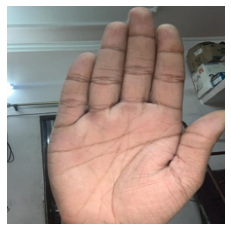

In [0]:
img_path = '/content/gdrive/My Drive/palm.jpg'
img, top_p, top_classes, real_class = predict(img_path, model1_trained)
_ = imshow_tensor(img)
print(top_p, top_classes, real_class)

In [0]:
model2 = get_pretrained_densenet('densenet121_2')
criterion = nn.NLLLoss()
optimizer = optim.Adam(model2.parameters())
save_file_name = 'densenet121-handgestures-2.pt'
#lets check the trainable parameters
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)
       

torch.Size([256, 1024])
torch.Size([256])
torch.Size([5, 256])
torch.Size([5])


In [0]:
model2.class_to_idx = data['train'].class_to_idx
model2.idx_to_class = {
    idx: class_
    for class_, idx in model2.class_to_idx.items()
}

list(model1.idx_to_class.items())

[(0, 'L'), (1, 'fantastic'), (2, 'fist'), (3, 'palm'), (4, 'victory')]

In [0]:
model2_trained, history = train(
    model2,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=7,
    n_epochs=50)
    

Model has been trained for: 24 epochs.


Epoch: 0 	Training Loss: 0.1202 	Validation Loss: 0.2605
		Training Accuracy: 95.62%	 Validation Accuracy: 90.73%

Epoch: 1 	Training Loss: 0.1496 	Validation Loss: 0.2698
		Training Accuracy: 94.80%	 Validation Accuracy: 90.89%

Epoch: 2 	Training Loss: 0.1395 	Validation Loss: 0.2462
		Training Accuracy: 95.21%	 Validation Accuracy: 90.56%

Epoch: 3 	Training Loss: 0.1611 	Validation Loss: 0.2521
		Training Accuracy: 94.27%	 Validation Accuracy: 91.57%

Epoch: 4 	Training Loss: 0.1391 	Validation Loss: 0.2195
		Training Accuracy: 95.56%	 Validation Accuracy: 91.74%

Epoch: 5 	Training Loss: 0.1314 	Validation Loss: 0.2242
		Training Accuracy: 95.56%	 Validation Accuracy: 92.92%

Epoch: 6 	Training Loss: 0.1419 	Validation Loss: 0.2247
		Training Accuracy: 95.21%	 Validation Accuracy: 93.09%

Epoch: 7 	Training Loss: 0.1224 	Validation Loss: 0.2409
		Training Accuracy: 95.85%	 Validation Accuracy: 90.39%

Epoch: 8 	Training Loss: 0.1477 	Valida

Text(0.5, 1.0, 'Training and Validation Losses')

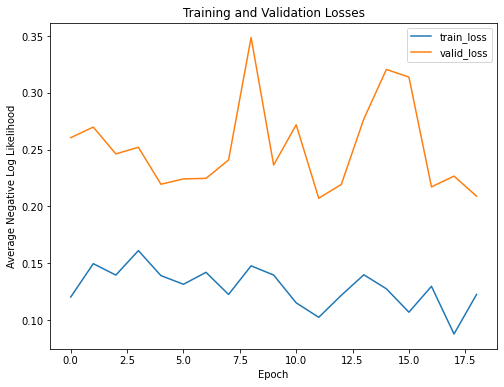

In [0]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

Text(0.5, 1.0, 'Training and Validation Accuracy')

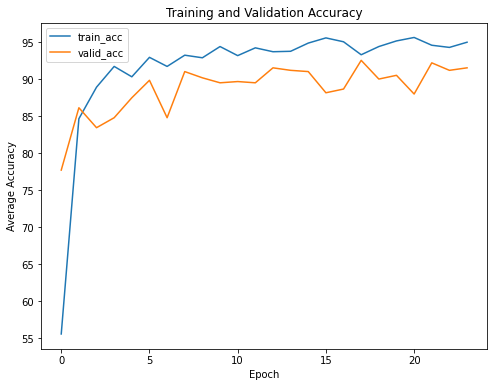

In [0]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

[0.9976339  0.00235722] ['victory', 'fantastic'] victory


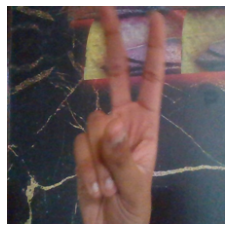

In [0]:
img_path = test_dir + '/victory/image_101.jpg'
img, top_p, top_classes, real_class = predict(img_path, model2_trained)
_ = imshow_tensor(img)
print(top_p, top_classes, real_class)

In [0]:
a=[]
b=[]
for i in range(10):
    testiter = iter(dataloaders['test'])
    # Get a batch of testing images and labels
    features, targets = next(testiter)
    if train_on_gpu:
        x = accuracy(model2_trained(features.to('cuda')), targets, topk=(1, 2))[0]
        y = accuracy(model2_trained(features.to('cuda')), targets, topk=(1, 2))[1]
        print(x,y)
        a.append(x)
        b.append(y)
    else:
        print(accuracy(model2_trained(features), targets, topk=(1, 2)))
        a.append(accuracy(model2_trained(features.to('cuda')), targets, topk=(1, 2))[0])
        b.append(accuracy(model2_trained(features.to('cuda')), targets, topk=(1, 2))[1])
print(sum(a)/10)
print(sum(b)/10)

93.75 98.4375
93.75 98.4375
92.1875 96.875
87.5 96.875
92.1875 98.4375
95.3125 98.4375
93.75 98.4375
90.625 98.4375
90.625 98.4375
92.1875 100.0
92.1875
98.28125


[0.8391875  0.15864675] ['fantastic', 'palm'] My Drive


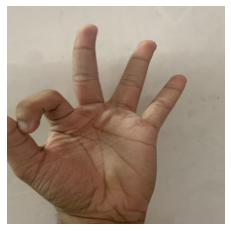

In [0]:
img_path = '/content/gdrive/My Drive/fantastic2.jpg'
img, top_p, top_classes, real_class = predict(img_path, model2_trained)
_ = imshow_tensor(img)
print(top_p, top_classes, real_class)

In [0]:
model3 = get_pretrained_densenet('densenet121_3')
criterion = nn.NLLLoss()
optimizer = optim.Adam(model3.parameters())
save_file_name = 'densenet121-handgestures-3.pt'
#lets check the trainable parameters
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)
       

torch.Size([256, 1024])
torch.Size([256])
torch.Size([5, 256])
torch.Size([5])


In [0]:
model3.class_to_idx = data['train'].class_to_idx
model3.idx_to_class = {
    idx: class_
    for class_, idx in model3.class_to_idx.items()
}

list(model3.idx_to_class.items())

[(0, 'L'), (1, 'fantastic'), (2, 'fist'), (3, 'palm'), (4, 'victory')]

In [0]:
model3_trained, history = train(
    model3,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=7,
    n_epochs=50)
    

Starting Training from Scratch.


Epoch: 0 	Training Loss: 1.3490 	Validation Loss: 1.0519
		Training Accuracy: 44.83%	 Validation Accuracy: 73.19%

Epoch: 1 	Training Loss: 0.7928 	Validation Loss: 0.7833
		Training Accuracy: 75.92%	 Validation Accuracy: 73.19%

Epoch: 2 	Training Loss: 0.6102 	Validation Loss: 0.5229
		Training Accuracy: 79.54%	 Validation Accuracy: 87.52%

Epoch: 3 	Training Loss: 0.4701 	Validation Loss: 0.4338
		Training Accuracy: 85.51%	 Validation Accuracy: 88.87%

Epoch: 4 	Training Loss: 0.3933 	Validation Loss: 0.4530
		Training Accuracy: 86.32%	 Validation Accuracy: 85.50%

Epoch: 5 	Training Loss: 0.3709 	Validation Loss: 0.4334
		Training Accuracy: 88.19%	 Validation Accuracy: 84.65%

Epoch: 6 	Training Loss: 0.3266 	Validation Loss: 0.4245
		Training Accuracy: 88.37%	 Validation Accuracy: 85.50%

Epoch: 7 	Training Loss: 0.2966 	Validation Loss: 0.3485
		Training Accuracy: 90.59%	 Validation Accuracy: 88.20%

Epoch: 8 	Training Loss: 0.3043 	Validation Lo

Text(0.5, 1.0, 'Training and Validation Losses')

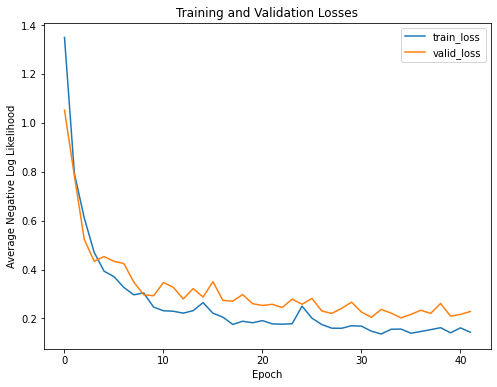

In [0]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

Text(0.5, 1.0, 'Training and Validation Accuracy')

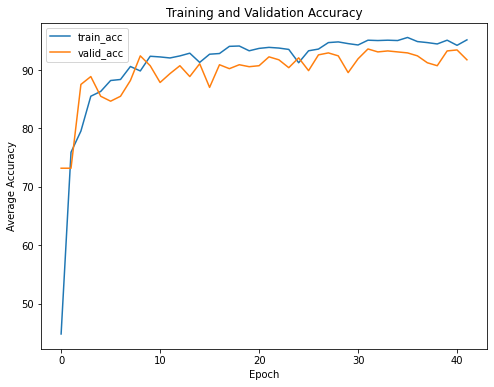

In [0]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

[0.99781466 0.00214117] ['victory', 'fantastic'] victory


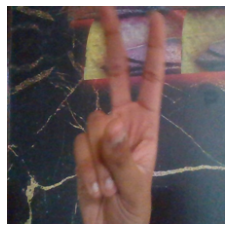

In [0]:
img_path = test_dir + '/victory/image_101.jpg'
img, top_p, top_classes, real_class = predict(img_path, model3_trained)
_ = imshow_tensor(img)
print(top_p, top_classes, real_class)

In [0]:
a=[]
b=[]
for i in range(20):
    testiter = iter(dataloaders['test'])
    # Get a batch of testing images and labels
    features, targets = next(testiter)
    if train_on_gpu:
        x = accuracy(model2_trained(features.to('cuda')), targets, topk=(1, 2))[0]
        y = accuracy(model2_trained(features.to('cuda')), targets, topk=(1, 2))[1]
        print(x,y)
        a.append(x)
        b.append(y)
    else:
        print(accuracy(model2_trained(features), targets, topk=(1, 2)))
        a.append(accuracy(model2_trained(features.to('cuda')), targets, topk=(1, 2))[0])
        b.append(accuracy(model2_trained(features.to('cuda')), targets, topk=(1, 2))[1])
print(sum(a)/20)
print(sum(b)/20)

92.1875 100.0
92.1875 98.4375
90.625 98.4375
92.1875 98.4375
92.1875 100.0
89.0625 96.875
89.0625 95.3125
95.3125 98.4375
95.3125 96.875
92.1875 98.4375
92.1875 95.3125
85.9375 98.4375
93.75 100.0
87.5 92.1875
95.3125 98.4375
96.875 98.4375
87.5 96.875
92.1875 100.0
95.3125 100.0
93.75 98.4375
92.03125
97.96875


[0.90243274 0.09001781] ['palm', 'fist'] My Drive


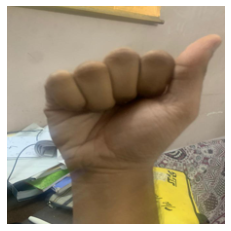

In [0]:
img_path = '/content/gdrive/My Drive/fist.jpg'
img, top_p, top_classes, real_class = predict(img_path, model3_trained)
_ = imshow_tensor(img)
print(top_p, top_classes, real_class)